# EM for GPB2 using Constant Velocity Model 

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from copy import copy
from datetime import datetime, timedelta

from stonesoup.functions import gm_reduce_single

from stonesoup.predictor.kalman import KalmanPredictor
from stonesoup.updater.kalman import KalmanUpdater
from stonesoup.predictor.imm import IMMPredictor
from stonesoup.updater.imm import IMMUpdater
from stonesoup.models.transition.linear import ConstantVelocity, \
    CombinedLinearGaussianTransitionModel, LinearGaussianTimeInvariantTransitionModel, RandomWalk

from stonesoup.models.measurement.linear import LinearGaussian

from stonesoup.types.state import GaussianState
from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.detection import Detection
from stonesoup.types.state import StateVector, CovarianceMatrix, \
    GaussianMixtureState, WeightedGaussianState
from stonesoup.types.track import Track

from stonesoup.simulator.simple import SingleTargetGroundTruthSimulator

from matplotlib.patches import Ellipse


In [2]:
from emgpb2.states import Gaussian as EMGPB2Gaussian
from emgpb2.states import GMM as EMGPB2GMM
from emgpb2.states import GMMSequence as EMGPB2GMMSequence
from emgpb2.models import RandomWalk as EMGPB2RandomWalk
from emgpb2.models import ConstantVelocity as EMGPB2ConstantVelocity
from emgpb2.EM import SKFEstimator
from emgpb2.utils import Utility

## Scenarios: choose one scenario

Scenario 0: EM GPB2 works fine. The estimated track is very similar to the groundtruth.

Scenario 1: EM GPB2 works fine. But two models converged to same paramters.

In [3]:
Scenario = 0

## Groundtruth parameters.

### Define two constant velocity models.

In [4]:
# dimension of state vector and observation
state_dim = 2
obs_dim = 2

# iteration numbers of two models
iter_model_1 = 220
iter_model_2 = 180

# Define scenarios groundtruth part
if Scenario == 0:
    gt_process_sigma_1 = 2.0
    gt_process_sigma_2 = 10.0
    gt_measurement_sigma_1 = 0.5
    gt_measurement_sigma_2 = 0.75
elif Scenario == 1:
    gt_process_sigma_1 = 0.5
    gt_process_sigma_2 = 2.0
    gt_measurement_sigma_1 = 3.5
    gt_measurement_sigma_2 = 1.5
    

# define transition models
gt_transition_model_1 = CombinedLinearGaussianTransitionModel(
                        (RandomWalk(gt_process_sigma_1 ** 2),
                         RandomWalk(gt_process_sigma_1 ** 2)))
gt_transition_model_2 = CombinedLinearGaussianTransitionModel(
                        (RandomWalk(gt_process_sigma_2 ** 2),
                         RandomWalk(gt_process_sigma_2 ** 2)))

# define measurement models
mesurement_noise_1 = np.diag([gt_measurement_sigma_1 ** 2, gt_measurement_sigma_1 ** 2])
measurement_model_1 = LinearGaussian(ndim_state=2, mapping=[0, 1], noise_covar=mesurement_noise_1)
mesurement_noise_2 = np.diag([gt_measurement_sigma_2 ** 2, gt_measurement_sigma_2 ** 2])
measurement_model_2 = LinearGaussian(ndim_state=2, mapping=[0, 1], noise_covar=mesurement_noise_2)


## Suppose we don't know the parameters of the models.
## We guess a set of parameters for IMM.

In [5]:
# Define scenarios groundtruth part
if Scenario == 0:
    init_P = [5.0, 5.0]
    q = [1.0, 20.0]
    r = [3.0, 3.0]
elif Scenario == 1:
    init_P = [1.0, 3.0]
    q = [0.1, 5.0]
    r = [3.0, 3.0]

## Generate groundtruth and detections.

In [6]:
# generate groundtruth
gt_track = []
gt_time = []
timestamp_init = datetime.now()

# model 1
state_init_1 = GaussianState(StateVector(np.zeros((state_dim, 1))),
                           CovarianceMatrix(np.zeros((state_dim, state_dim))),
                           timestamp=timestamp_init)
gt_generator_1 = SingleTargetGroundTruthSimulator(gt_transition_model_1, state_init_1, number_steps=iter_model_1)
for time, gnd_paths in gt_generator_1.groundtruth_paths_gen():
    gnd_path = gnd_paths.pop()
    gt_track.append(gnd_path.state)
    gt_time.append(time)

# model 2
state_init_2 = GaussianState(gt_track[-1].state_vector, 
                             CovarianceMatrix(np.zeros((state_dim, state_dim))), 
                             timestamp=gt_time[-1])
gt_generator_2 = SingleTargetGroundTruthSimulator(gt_transition_model_2, state_init_2, number_steps=iter_model_2)
for time, gnd_paths in gt_generator_2.groundtruth_paths_gen():
    gnd_path = gnd_paths.pop()
    gt_track.append(gnd_path.state)
    gt_time.append(time)

# generate detections (adding noise)
# model 1
detection_track = []
for i in range(iter_model_1):
    m_ = Detection(measurement_model_1.function(gt_track[i].state_vector, measurement_model_1.rvs(1)), gt_time[i])
    detection_track.append(m_)
# model 2
for i in range(iter_model_2):
    ii = i + iter_model_1
    m_ = Detection(measurement_model_2.function(gt_track[ii].state_vector, measurement_model_2.rvs(1)), gt_time[ii])
    detection_track.append(m_)

## Perform IMM using groundtruth paramters.

In [7]:
# model transition probability
model_transition_matrix = np.array([[0.5, 0.5],
                                    [0.5, 0.5]])

# define two kalman predictors. re-use the groundtruth transition model.
predictor_1 = KalmanPredictor(gt_transition_model_1)
predictor_2 = KalmanPredictor(gt_transition_model_2)

# define IMM predictor
imm_predictor = IMMPredictor([predictor_1, predictor_2],
                             model_transition_matrix)

# define two kalman updaters. re-use the groundtruth measurement model.
updater_1 = KalmanUpdater(measurement_model_1)
updater_2 = KalmanUpdater(measurement_model_2)

# define IMM updater
imm_updater = IMMUpdater([updater_1, updater_2], model_transition_matrix)

# initialise state for kalman filter 1
ft_state_init_1 = WeightedGaussianState(StateVector(np.zeros((state_dim, 1))),
                                      CovarianceMatrix(np.eye(state_dim) * 1.0),
                                      timestamp=timestamp_init,
                                      weight=0.5)

# initialise state for kalman filter 2
ft_state_init_2 = WeightedGaussianState(StateVector(np.zeros((state_dim, 1))),
                                      CovarianceMatrix(np.eye(state_dim) * 1.0),
                                      timestamp=timestamp_init,
                                      weight=0.5)

# define Gaussian Mixture model for initial state
prior = GaussianMixtureState([ft_state_init_1, ft_state_init_2])
track = Track([copy(prior)])

# tracking
track_error = []
for i in range(1, len(detection_track)-1):
    # measurement
    measurement = detection_track[i]
    # State prediction
    prediction = imm_predictor.predict(track.state, timestamp=gt_time[i])
    # Measurement prediction
    meas_prediction = imm_updater.predict_measurement(prediction)
    # Association
    hyp = SingleHypothesis(prediction, measurement)
    # State update
    prior = imm_updater.update(hyp)
    track.append(prior)
    track_error.append(measurement_model_1.function(track[i].state_vector, np.zeros((obs_dim, 1)))
                       - measurement_model_1.function(gt_track[i].state_vector, np.zeros((obs_dim, 1))))

## The Root Mean Squared Error (RMSE) between the estimated track (groundtruth paramters) and the groundtruth.

In [8]:
track_error = np.asarray(track_error)
track_error = np.squeeze(track_error)
rmse_tmp = []
for track_error_ in track_error:
    rmse_tmp.append(track_error_ @ track_error_.T)
rmse = np.sqrt(np.mean(np.array(rmse_tmp)))
print("RMSE: " + str(rmse))

RMSE: 0.915968605436958


## Perform IMM using guessed paramters.

In [9]:
# define model transition probability
ft_model_transition_matrix = np.array([[0.5, 0.5],
                                       [0.5, 0.5]])
# define transition model 1 using guessed parameter
ft_transition_model_1 = CombinedLinearGaussianTransitionModel(
                        (RandomWalk(q[0] ** 2),
                         RandomWalk(q[0] ** 2)))
# define transition model 2 using guessed parameter
ft_transition_model_2 = CombinedLinearGaussianTransitionModel(
                        (RandomWalk(q[1] ** 2),
                         RandomWalk(q[1] ** 2)))

# define measurement model. use same measurement model for two Kalman filters.
ft_measurement_noise = np.diag([r[0] ** 2, r[0] ** 2])
ft_measurement_model = LinearGaussian(ndim_state=2, mapping=[0, 1],
                                   noise_covar=ft_measurement_noise)

# define two kalman updaters.
ft_predictor_1 = KalmanPredictor(ft_transition_model_1)
ft_predictor_2 = KalmanPredictor(ft_transition_model_2)

# define IMM predictor
ft_imm_predictor = IMMPredictor([ft_predictor_1, ft_predictor_2], ft_model_transition_matrix)

# define IMM updater. use same measurement model for two Kalman filters.
ft_updater = KalmanUpdater(ft_measurement_model)
ft_imm_updater = IMMUpdater([copy(ft_updater), copy(ft_updater)], ft_model_transition_matrix)

# define Gaussian Mixture model for initial state. We used the same initial state as previous filter.
prior = GaussianMixtureState([ft_state_init_1, ft_state_init_2])
track = Track([copy(prior)])
track_error = []

for i in range(1, len(detection_track)-1):
    # measurement
    measurement = detection_track[i]
    # State prediction
    prediction = ft_imm_predictor.predict(track.state, timestamp=gt_time[i])
    # Measurement prediction
    meas_prediction = ft_imm_updater.predict_measurement(prediction)
    # Association
    hyp = SingleHypothesis(prediction, measurement)
    # State update
    prior = ft_imm_updater.update(hyp)
    track.append(prior)
    track_error.append(ft_measurement_model.function(track[i].state_vector, np.zeros((2,1))) - ft_measurement_model.function(gt_track[i].state_vector, np.zeros((2,1))))

## The Root Mean Squared Error (RMSE) between the estimated track (guessed parameters) and the groundtruth.

In [10]:
track_error = np.asarray(track_error)
track_error = np.squeeze(track_error)
rmse_tmp = []
for track_error_ in track_error:
    rmse_tmp.append(track_error_ @ track_error_.T)
rmse = np.sqrt(np.mean(np.array(rmse_tmp)))
print("RMSE: " + str(rmse))

RMSE: 2.1153188808511234


## Run EMGPB2 to estimate IMM parameters.

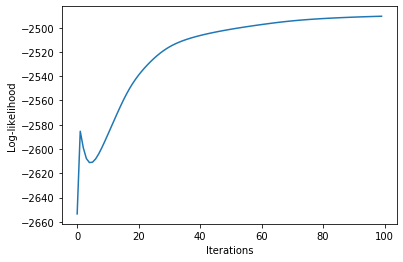

In [11]:
num_of_models = len(q)
gaussian_models = []
for i in range(num_of_models):
    gaussian_models.append(EMGPB2Gaussian(np.zeros([state_dim, 1]), (init_P[i] ** 2) * np.eye(state_dim)))
initial_gmm_state = EMGPB2GMM(gaussian_models)

# measurement sequence
detection_track_EMGPB2 = [ele.state_vector for ele in detection_track]
gmmsequence = EMGPB2GMMSequence(np.float64(detection_track_EMGPB2), initial_gmm_state)
dataset = [gmmsequence]

# Initial models. use guessed parameters.
randomwalk_models = []
for i in range(num_of_models):
    randomwalk_models.append(EMGPB2RandomWalk(q=q[i], r=r[i], state_dim=state_dim))

# Switching matrix probability
Z = np.ones((2, 2)) / 2

new_models_all, Z_all, dataset, LLs = SKFEstimator.EM(dataset, randomwalk_models, Z,
                                                 max_iters=100, threshold=1e-8, learn_H=True, learn_R=True,
                                                 learn_A=True, learn_Q=True, learn_init_state=False, learn_Z=True,
                                                 diagonal_Q=False, wishart_prior=False, verbose=False)


new_models = new_models_all[-1]
Utility.draw_convergence_figure(LLs)

# new_models[0].Q = (new_models[0].Q + new_models[0].Q.T)/2
# new_models[1].Q = (new_models[1].Q + new_models[1].Q.T)/2
# new_models[0].R = (new_models[0].R + new_models[0].R.T)/2
# new_models[1].R = (new_models[1].R + new_models[1].R.T)/2

## Estimated parameters

In [12]:
for i, model_ in enumerate(new_models):
    print('Model ' + str(i))
    print('F ' + str(i) + ':')
    print(model_.A)
    print('H ' + str(i) + ':')
    print(model_.H)
    print('Q ' + str(i) + ':')
    print(model_.Q)
    print('R ' + str(i) + ':')
    print(model_.R)
    print('----------------------------')

Model 0
F 0:
[[ 0.96571872 -0.05418964]
 [-0.0332486   0.97655537]]
H 0:
[[0.96766394 0.00566883]
 [0.02422813 0.99030414]]
Q 0:
[[ 4.60839893 -0.81169791]
 [-0.81620895  4.90381641]]
R 0:
[[ 0.4045703  -0.10313241]
 [-0.10556537  0.70579255]]
----------------------------
Model 1
F 1:
[[0.95240841 0.01281632]
 [0.01715294 1.01156063]]
H 1:
[[0.96678731 0.00649698]
 [0.02860189 0.99064755]]
Q 1:
[[101.96511926 -10.14761626]
 [-10.15417736 114.74531597]]
R 1:
[[ 0.48779325 -0.15196235]
 [-0.15550166  0.98286129]]
----------------------------


## Perform IMM using paramters estimated by EMGPB2.

In [13]:
# transition model
em_transition_model_1 = LinearGaussianTimeInvariantTransitionModel(transition_matrix=new_models[0].A,
                                                                   covariance_matrix=new_models[0].Q)
em_transition_model_2 = LinearGaussianTimeInvariantTransitionModel(transition_matrix=new_models[1].A,
                                                                   covariance_matrix=new_models[1].Q)

# measurement noises
em_measurement_noise_1 = new_models[0].R
em_measurement_noise_2 = new_models[1].R

# measurement model
em_measurement_model_1 = LinearGaussian(ndim_state=2, mapping=[0, 1], 
                                        noise_covar=em_measurement_noise_1)
em_measurement_model_2 = LinearGaussian(ndim_state=2, mapping=[0, 1], 
                                        noise_covar=em_measurement_noise_2)

em_model_transition_matrix = np.array([[0.5, 0.5],
                                       [0.5, 0.5]])
em_predictor_1 = KalmanPredictor(em_transition_model_1)
em_predictor_2 = KalmanPredictor(em_transition_model_2)
em_imm_predictor = IMMPredictor([em_predictor_1, em_predictor_2], em_model_transition_matrix)

em_updater_1 = KalmanUpdater(em_measurement_model_1)
em_updater_2 = KalmanUpdater(em_measurement_model_2)
em_imm_updater = IMMUpdater([em_updater_1, em_updater_2], em_model_transition_matrix)

em_state_init = WeightedGaussianState(StateVector(np.zeros((state_dim, 1))),
                                      CovarianceMatrix(np.eye(state_dim) * init_P[0]),
                                      timestamp=timestamp_init,
                                      weight=0.5)

prior = GaussianMixtureState([copy(em_state_init), copy(em_state_init)])
track = Track([copy(prior)])
track_error = []

for i in range(1, len(detection_track)-1):
    # measurement
    measurement = detection_track[i]
    # State prediction
    prediction = em_imm_predictor.predict(track.state, timestamp=gt_time[i])
    # Measurement prediction
    meas_prediction = em_imm_updater.predict_measurement(prediction)
    # Association
    hyp = SingleHypothesis(prediction, measurement)
    # State update
    prior = em_imm_updater.update(hyp)
    track.append(prior)
    track_error.append(em_measurement_model_1.function(track[i].state_vector, np.zeros((2,1))) - em_measurement_model_1.function(gt_track[i].state_vector, np.zeros((2,1))))

## The Root Mean Squared Error (RMSE) between the estimated track (guessed parameters) and the groundtruth.

In [14]:
track_error = np.asarray(track_error)
track_error = np.squeeze(track_error)
rmse_tmp = []
for track_error_ in track_error:
    rmse_tmp.append(track_error_ @ track_error_.T)
rmse = np.sqrt(np.mean(np.array(rmse_tmp)))
print("RMSE: " + str(rmse))

RMSE: 0.9174128684373315
